In [93]:
from ultralytics import YOLO
import cv2
from ultralytics.utils.plotting import Annotator
import math
from PIL import Image
import imutils

In [94]:
model = YOLO('yolov9c.pt')
names = model.model.names

In [95]:
img = cv2.imread('./../datasets/images/distance_detection/11.jpeg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), 0)

In [96]:
dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)
arucoParams = cv2.aruco.DetectorParameters()
corners = cv2.aruco.detectMarkers(gray, dictionary, parameters=arucoParams)[0]

In [97]:
assert len(corners) > 0, "No ArUco marker detected"

In [98]:
markerCorner = corners[0]

In [99]:
# Aruco Perimeter
aruco_perimeter = cv2.arcLength(markerCorner, True)
# Pixel to cm ratio
# perimeter of the aruco marker is 28 centimeters (7cm x 4).
pixel_per_cm = aruco_perimeter / 28

In [100]:
print("ArUco Perimeter: {}".format(aruco_perimeter))
print("Pixel to cm ratio: {}".format(pixel_per_cm))

ArUco Perimeter: 1816.6629333496094
Pixel to cm ratio: 64.88081904820034


In [101]:
h, w = img.shape[:2]

In [102]:
cnts = cv2.findContours(gray.copy(), cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

In [103]:
center_point = (w//2, h)

In [104]:
# Example calculation of pixel_per_meter for a given object size in pixels and real world size in meters.
pixel_per_meter = pixel_per_cm * 100

In [105]:
txt_color, txt_background, bbox_clr = ((0, 0, 0), (255, 255, 255), (255, 0, 255))

In [110]:
annotator = Annotator(img, line_width=2)

In [111]:
results = model.track(img, persist=True)
boxes = results[0].boxes.xyxy.cpu()

0: 640x480 1 refrigerator, 726.9ms
Speed: 3.1ms preprocess, 726.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


In [112]:
if results[0].boxes.id is not None:
    track_ids = results[0].boxes.id.int().cpu().tolist()

    for box, track_id in zip(boxes, track_ids):
        annotator.box_label(box, label=str(track_id), color=bbox_clr)
        annotator.visioneye(box, center_point)

        x1, y1 = int((box[0] + box[2]) // 2), int((box[1] + box[3]) // 2)    # Bounding box centroid

        distance = (math.sqrt((x1 - center_point[0]) ** 2 + (y1 - center_point[1]) ** 2))/pixel_per_meter
        distance_per_centimeter = distance * 100

        text_size, _ = cv2.getTextSize(f"Distance: {distance_per_centimeter:.2f} cm", cv2.FONT_HERSHEY_SIMPLEX,1.2, 3)
        cv2.rectangle(img, (x1, y1 - text_size[1] - 10),(x1 + text_size[0] + 10, y1), txt_background, -1)
        cv2.putText(img, f"Distance: {distance_per_centimeter:.2f} cm",(x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 1.2,txt_color, 3)

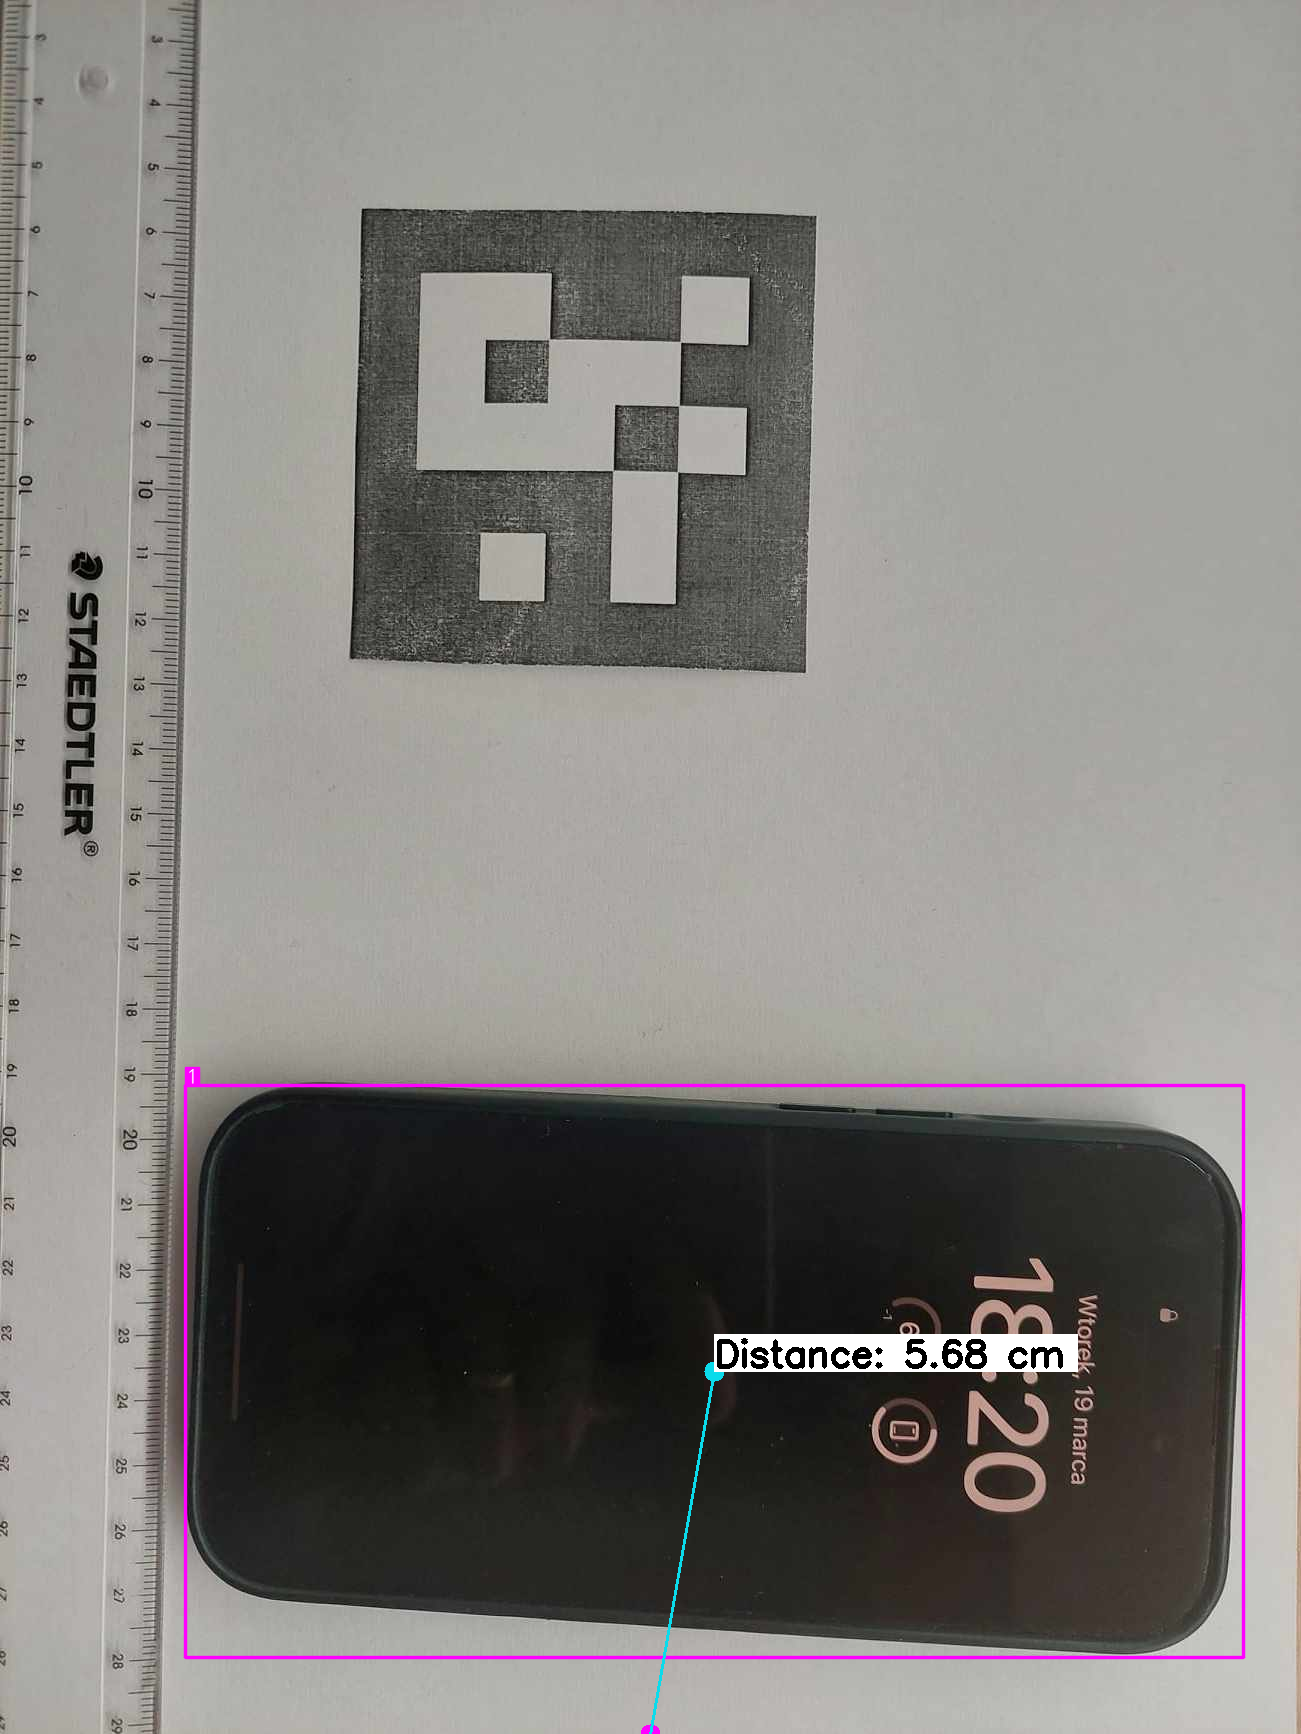

In [113]:
preview = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Converting BGR to RGB
display(Image.fromarray(preview))